In [2]:
# from rdkit import Chem
# from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer

# smiles = "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
# tokenizer = BasicSmilesTokenizer()
# tokens = tokenizer.tokenize(smiles)
# print("Tokenized SMILES:", tokens)

In [2]:
from transformers import BertTokenizer, BertModel

# Use a pre-trained tokenizer and model (e.g., ChemBERTa)
tokenizer = BertTokenizer.from_pretrained(
    "seyonec/SMILES_tokenized_PubChem_shard00_160k"
)
model = BertModel.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")

# Tokenize SMILES string
inputs = tokenizer("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", return_tensors="pt")
outputs = model(**inputs)

# Get the embeddings
smiles_embedding = outputs.last_hidden_state
print("SMILES Embedding Shape:", smiles_embedding.shape)
# SMILES Embedding Shape: torch.Size([1, 26, 768])

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.d

SMILES Embedding Shape: torch.Size([1, 26, 768])


model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

In [3]:
smiles_embedding_np = smiles_embedding.detach().cpu().numpy()  # Convert to NumPy array
smiles_embedding_np

array([[[-8.7590200e-01,  3.0506086e-01,  6.9207108e-01, ...,
          5.4176462e-01,  5.5791640e-01, -5.0844544e-01],
        [-1.2149686e+00,  4.3680158e-01, -4.5811260e-01, ...,
          6.9964379e-01,  1.6057323e+00,  1.6602541e+00],
        [-1.0540334e+00,  7.6476914e-01, -1.2318478e+00, ...,
          2.3868134e+00,  2.2018609e+00,  1.3283165e-03],
        ...,
        [-1.0319257e+00, -2.1826245e-01, -8.8171393e-02, ...,
          1.7335273e+00,  1.4440529e+00, -5.0599241e-01],
        [-2.7555614e+00,  1.7899810e-01, -5.9625320e-02, ...,
         -2.3788512e-01, -4.2273989e-01,  1.8023103e-01],
        [-1.8629063e+00, -2.4388081e-01, -4.4336745e-01, ...,
         -5.4076403e-02,  1.4175699e+00, -9.9230146e-01]]], dtype=float32)

In [4]:
smiles_embedding_np.shape

(1, 26, 768)

# Data preparation

In [4]:
import pandas as pd
import numpy as np
import joblib

In [7]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)

(1241, 3)


In [8]:
pd_train["label"].value_counts()

label
1    683
0    558
Name: count, dtype: int64

In [9]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)

(286, 3)


In [10]:
pd_test["label"].value_counts()

label
1    221
0     65
Name: count, dtype: int64

In [11]:
# Tokenize and embed each SMILES string
def embed_smiles(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", max_length=514, truncation=True)
    outputs = model(**inputs)
    # Use mean pooling to create a fixed-size embedding
    embedding = outputs.last_hidden_state.mean(dim=1)
    return embedding.detach().cpu().numpy()


# Apply embedding to each SMILES string
pd_train["Embeddings"] = pd_train["Smiles"].apply(embed_smiles)

# Save the embeddings
joblib.dump(pd_train, "data_smiles/Training_Group_embeddings.pkl")

['data_smiles/Training_Group_embeddings.pkl']

In [12]:
pd_test["Embeddings"] = pd_test["Smiles"].apply(embed_smiles)
joblib.dump(pd_test, "data_smiles/Testing_Group_embeddings.pkl")

['data_smiles/Testing_Group_embeddings.pkl']

In [13]:
# load the embeddings
pd_train = joblib.load("data_smiles/Training_Group_embeddings.pkl")
pd_test = joblib.load("data_smiles/Testing_Group_embeddings.pkl")

In [14]:
# Prepare features and labels for the split
X_train = np.vstack(pd_train["Embeddings"].values)  # Stack embeddings into a 2D array
y_train = pd_train["label"].values

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (1241, 768)
y_train Shape: (1241,)


In [15]:
X_test = np.vstack(pd_test["Embeddings"].values)  # Stack embeddings into a 2D array
y_test = pd_test["label"].values

print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (286, 768)
y_test Shape: (286,)


# Model training

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat


def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [37]:
# lr = 0.01
# epochs = 200
# batch_size = 128

random_state = 2

lr=0.07157358459955648
epochs=101
batch_size=256

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [38]:
train_accs = []
train_losses = []
test_accs = []
test_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    test_batch_losses = []
    test_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i : i + batch_size]
        y_i = y_train[i : i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_test_hat = predict(X_test, theta)
        test_loss = compute_loss(y_test_hat, y_test)
        test_batch_losses.append(test_loss)

        test_acc = compute_accuracy(X_test, y_test, theta)
        test_batch_accs.append(test_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    test_batch_loss = sum(test_batch_losses) / len(test_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    test_batch_acc = sum(test_batch_accs) / len(test_batch_accs)

    train_losses.append(train_batch_loss)
    test_losses.append(test_batch_loss)
    train_accs.append(train_batch_acc)
    test_accs.append(test_batch_acc)

    print(
        f"\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\ttestidation loss: {test_batch_loss:.3f}"
    )


EPOCH 1:	Training loss: 3.957	testidation loss: 2.571

EPOCH 2:	Training loss: 3.610	testidation loss: 2.393

EPOCH 3:	Training loss: 3.307	testidation loss: 2.390

EPOCH 4:	Training loss: 3.634	testidation loss: 2.261

EPOCH 5:	Training loss: 3.239	testidation loss: 2.717

EPOCH 6:	Training loss: 3.349	testidation loss: 2.978

EPOCH 7:	Training loss: 3.680	testidation loss: 2.318

EPOCH 8:	Training loss: 3.635	testidation loss: 2.162

EPOCH 9:	Training loss: 3.201	testidation loss: 2.732

EPOCH 10:	Training loss: 3.283	testidation loss: 3.019

EPOCH 11:	Training loss: 3.727	testidation loss: 2.255

EPOCH 12:	Training loss: 3.627	testidation loss: 2.262

EPOCH 13:	Training loss: 3.184	testidation loss: 2.634

EPOCH 14:	Training loss: 3.465	testidation loss: 2.547

EPOCH 15:	Training loss: 3.456	testidation loss: 2.499

EPOCH 16:	Training loss: 3.003	testidation loss: 1.828

EPOCH 17:	Training loss: 3.248	testidation loss: 2.285

EPOCH 18:	Training loss: 3.605	testidation loss: 2.128



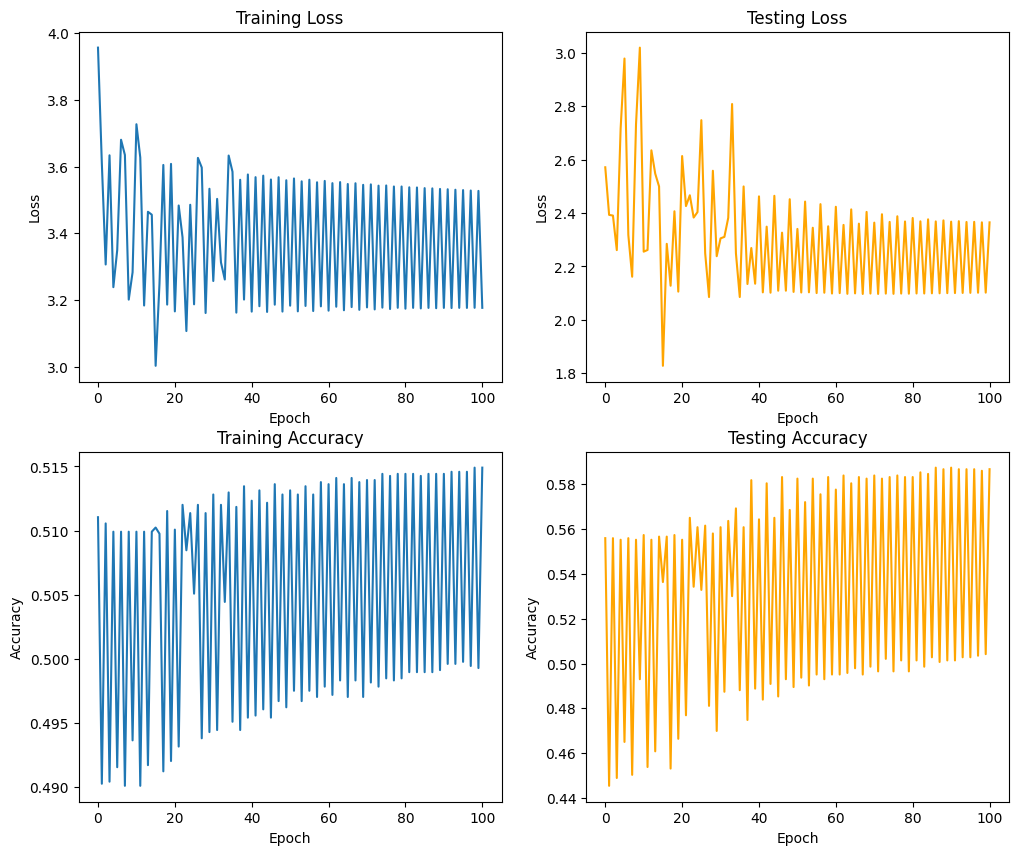

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(test_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Testing Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(test_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Testing Accuracy")

plt.show()

In [40]:
test_set_acc = compute_accuracy(X_test, y_test, theta)
print("Evaluation on validation and test set:")
print(f"Accuracy: {test_set_acc}")

Evaluation on validation and test set:
Accuracy: 0.7727272727272727


In [41]:
# compute auc, precision, recall
from sklearn.metrics import roc_auc_score, precision_score, recall_score

y_test_hat = predict(X_test, theta)
auc = roc_auc_score(y_test, y_test_hat)
precision = precision_score(y_test, y_test_hat.round())
recall = recall_score(y_test, y_test_hat.round())

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

AUC: 0.666
Precision: 0.773
Recall: 1.000


# Model optuna

In [24]:
import optuna


In [25]:
# Optuna Objective function to optimize AUC
def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    epochs = trial.suggest_int("epochs", 50, 500)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # Initialize parameters
    theta = np.random.uniform(size=X_train.shape[1])
    train_losses = []
    test_losses = []
    test_aucs = []

    # Training loop
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]

            # Forward pass and loss
            y_hat = predict(X_batch, theta)
            train_loss = compute_loss(y_hat, y_batch)
            gradient = compute_gradient(X_batch, y_batch, y_hat)
            theta = update_theta(theta, gradient, lr)

        # Calculate AUC on test data
        y_test_hat = predict(X_test, theta)
        test_auc = roc_auc_score(y_test, y_test_hat)
        test_aucs.append(test_auc)

        # Stop early if AUC is satisfactory
        trial.report(test_auc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return max(test_aucs)

In [26]:
# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


[I 2024-11-11 21:53:13,117] A new study created in memory with name: no-name-4acbacfa-9310-4cc0-a42d-719f04f57f93
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_1193/2620807037.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-11-11 21:53:13,692] Trial 0 finished with value: 0.5785241907413853 and parameters: {'lr': 0.0010673211866699369, 'epochs': 123, 'batch_size': 128}. Best is trial 0 with value: 0.5785241907413853.
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_1193/2620807037.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-1

In [27]:
# Display best trial
print("Best trial:")
trial = study.best_trial
print(f"  AUC Score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  AUC Score: 0.6954054994778978
  Params:
    lr: 0.07157358459955648
    epochs: 101
    batch_size: 256


# Model tuning

In [5]:
from tpot import TPOTClassifier

# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=6,  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

                                                                              
Generation 1 - Current best internal CV score: 0.631005816769892
                                                                             
Generation 2 - Current best internal CV score: 0.6410992739100967
                                                                             
Generation 3 - Current best internal CV score: 0.6411517098701781
                                                                             
Generation 4 - Current best internal CV score: 0.6411517098701781
                                                                              
Generation 5 - Current best internal CV score: 0.6411517098701781
                                                                              
Best pipeline: KNeighborsClassifier(ZeroCount(input_matrix), n_neighbors=27, p=2, weights=distance)


TPOTClassifier(generations=5, n_jobs=6, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [7]:
# Access the best pipeline directly after fitting
from pprint import pprint
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)


best_pipeline = tpot.fitted_pipeline_

#
y_pred = best_pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Extract model name and parameters
model_name = type(best_pipeline.steps[-1][1]).__name__  # Name of the final estimator
model_params = best_pipeline.steps[-1][1].get_params()  # Params of the final estimator

# Append results to list
result = {
    "Best model": best_pipeline,
    "Model Name": model_name,
    "Parameters": model_params,
    "AUC": auc,
    "Precision": precision,
    "Recall": recall,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
}

pprint(result)

{'AUC': np.float64(0.5876435781413156),
 'Best model': Pipeline(steps=[('zerocount', ZeroCount()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=27, weights='distance'))]),
 'Model Name': 'KNeighborsClassifier',
 'Parameters': {'algorithm': 'auto',
                'leaf_size': 30,
                'metric': 'minkowski',
                'metric_params': None,
                'n_jobs': None,
                'n_neighbors': 27,
                'p': 2,
                'weights': 'distance'},
 'Precision': np.float64(0.7955555555555556),
 'Recall': np.float64(0.8099547511312217),
 'Sensitivity': np.float64(0.8099547511312217),
 'Specificity': np.float64(0.2923076923076923)}
